In [1]:
import tensorflow as tf
import numpy as np
import gpflow

from sgptools.utils.metrics import *
from sgptools.utils.misc import *
from sgptools.models.continuous_sgp import *
from sgptools.utils.gpflow import get_model_params
from sgptools.utils.data import *

import matplotlib.pyplot as plt
plt.set_cmap("jet") 

np.random.seed(10)
tf.random.set_seed(10)

2024-03-30 15:14:31.290802: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 15:14:31.292505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 15:14:31.325682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 15:14:31.326937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 15:14:31.954875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<Figure size 640x480 with 0 Axes>

In [2]:
dataset = 'salinity'
dataset_path = '/home/kalvik/sgp-tools/datasets/salinity.nc'

X_train, y_train, X_test, y_test, candidates, X, y = get_dataset(dataset, 
                                                                 dataset_path,
                                                                 num_test=5000)

# Train the GP and get the model parameters
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                              lengthscales=[1.0, 1.0],
                                              optimizer='scipy')

2024-03-30 15:14:42.424414: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.61806           │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [0.83279 0.61963] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.14623           │
╘═══════════════

In [3]:
gpr = gpflow.models.GPR((X_train, y_train),
                        noise_variance=noise_variance,
                        kernel=kernel)
y_test = gpr.predict_f_samples(X_test).numpy()
y_train = gpr.predict_f_samples(X_train).numpy()

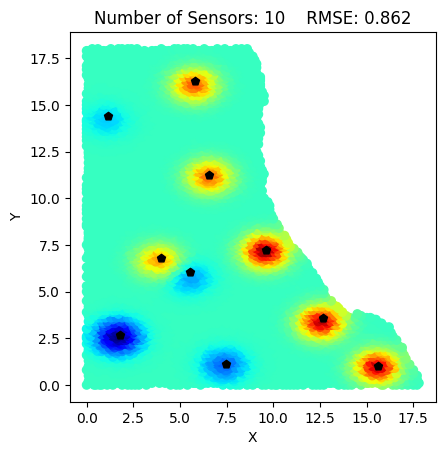

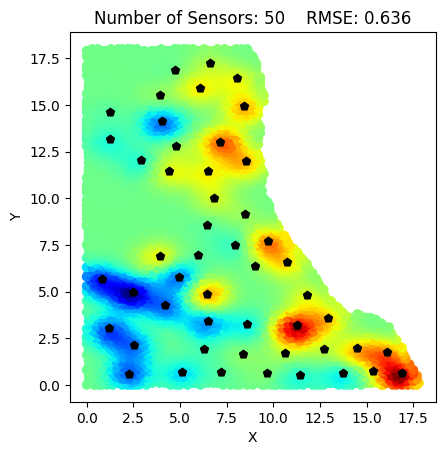

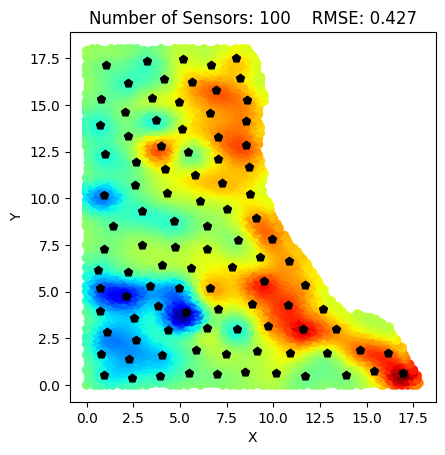

In [4]:
for num_placements in [10, 50, 100]:
  Xu_init = get_inducing_pts(X_train, num_placements)
  sgpr, _ = continuous_sgp(num_placements, 
                           X_train,
                           noise_variance=noise_variance,
                           kernel=kernel,
                           Xu_init=Xu_init, 
                           max_steps=1000)
  sgp_sol_sp = sgpr.inducing_variable.Z.numpy()

  Xu_X, Xu_y = cont2disc(sgp_sol_sp, 
                         candidates=X_test,
                         candidate_labels=y_test)

  # Get the GP predictions
  gpr = gpflow.models.GPR((Xu_X, Xu_y),
                          noise_variance=noise_variance,
                          kernel=kernel)
  y_pred, y_var = gpr.predict_f(X_test)
  y_pred = y_pred.numpy()

  rmse = np.sqrt(np.mean((y_pred - y_test)**2))

  plt.figure()
  plt.gca().set_aspect('equal')
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
  plt.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], c='k', marker='p')
  plt.title('Number of Sensors: {}    RMSE: {:.3f}'.format(num_placements, rmse))
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.savefig(f'stationary_{num_placements}.png', dpi=300, bbox_inches='tight')
  plt.show()

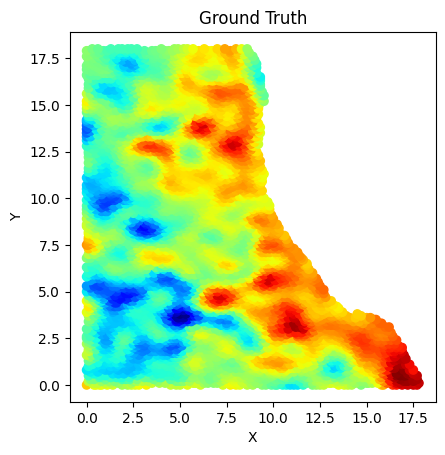

In [5]:
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.gca().set_aspect('equal')
plt.title('Ground Truth')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('stationary_demo_gt.png', dpi=300, bbox_inches='tight')
plt.show()